# Using the CRM class in clintrials

The CRM class is found here:

In [1]:
from clintrials.dosefinding.crm import CRM

We also import the logistic function and its inverse to use as the link functions in our examples.

In [2]:
from clintrials.common import logistic, inverse_logistic

The Continual Reassessment Method (CRM) is a model-based design for phase I clinical trials. The main goal of a phase I trial is to determine the maximum tolerated dose (MTD) of a new drug or treatment. The MTD is defined as the dose that is expected to produce a certain acceptable level of toxicity, often referred to as the target toxicity level.

### Key Components of CRM

*   **Aim**: The primary objective of the CRM is to find the dose with a dose-limiting toxicity (DLT) probability that is closest to a pre-specified target probability, $\theta$.

*   **Dose-Toxicity Model (Skeleton)**: The CRM assumes a mathematical model that describes the relationship between the dose level and the probability of toxicity. A common choice is a one-parameter logistic model:

    $$ P(\text{DLT at dose } d) = \frac{\exp(a + \beta d)}{1 + \exp(a + \beta d)} $$

    where $d$ represents the dose level, $a$ is a fixed constant, and $\beta$ is the parameter to be estimated. The set of initial estimates of toxicity probabilities for each dose level is known as the "skeleton".

*   **Prior Distribution**: The trial starts with a prior probability distribution for the parameter $\beta$. This prior reflects the investigators' initial beliefs about the toxicity of the doses before any patient data is collected. A normal distribution is often used for $\beta$, for example, $\beta \sim N(0, \sigma^2)$.

*   **Cohort Process and Bayesian Updating**: Patients are enrolled in small cohorts and assigned a dose. After the outcomes (DLT or no DLT) are observed for a cohort, the data is used to update the posterior distribution of $\beta$ using Bayes' theorem.

*   **Dose Assignment**: The dose for the next cohort of patients is the one that has an estimated DLT probability closest to the target $\theta$, based on the current posterior distribution of $\beta$. This process is repeated until a stopping rule is met, such as reaching the maximum sample size.

The dose with the posterior mean or median DLT rate closest to the target toxicity is then selected as the MTD.

### Example 1

On p.21 of his book, Ken Cheung gives an example of a CRM trial involving 5 doses. The prior expectations
of the probability of toxicity at each dose, elicited from a clinical investigator, are 5%, 12%, 25%, 40% and
55% respectively. The investigator wants to identify the dose with probability of toxicity closest to 25%.
The minimum model inputs are:

* an estimate of the prior probability of toxicity at each dose
* a desired level of toxicity to target

We enter:

In [3]:
prior = [0.05, 0.12, 0.25, 0.40, 0.55]
target_toxicity = 0.25

We tend to refer to the doses by their position in this list. For example, the investigator expects dose-level 2, to yield
a dose-limiting toxicity (DLT) in 12% of patients.

Create an instance of a CRM trial:

In [4]:
crm = CRM(prior, target_toxicity, first_dose=3, max_size=20, F_func=logistic, inverse_F=inverse_logistic)

I am using the logistic method here. It could be empiric, etc. See Ken Cheung's book, _Dose Finding with Continual Reassessment Method_.

In addition to the prior and target toxicity, we have provided some extra variables. We have told the trial that the starting dose will be dose-level 3, thethat  maximum trial size will be 20 patients, and that we wish to use the logistic function (and its inverse) to link codified dose levels to probabilities. 

As the trial progresses, we provide information on dose-levels administered and DLTs observed. The crm
function takes these inputs and provides outputs, including the dose recommended for the next patient by
the CRM algorithm.
Let’s say that we have registered and evaluated five patients in the trial:

* The first patient was given dose level 3 and did not have a DLT.
* The second patient was given dose level 5 and also did not have a DLT.
* The third patient was also given dose level 5 but did unfortunately have a DLT.
* The next two patients were given doses 3 and 4 and neither experienced DLT.

We create lists of dose levels given and binary toxicity events:

In [5]:
doses_given = [3, 5, 5, 3, 4]
toxicities = [0, 0, 1, 0, 0]
cases = list(zip(doses_given, toxicities))

The get the CRM design to advise us of the next dose, we update our CRM trial instance with the observed cases:

In [6]:
next_dose = crm.update(cases)
print(next_dose)

4


/app/clintrials/common.py:104: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-a0 - np.exp(beta) * x))


Based on the provided priors, the doses given and the resulting tolerance and toxicity events, the dose-level estimated to have probability closest to 25% is dose-level 4. This is the dose that the model advises giving to the 6th patient.

After our five observations, the posterior estimate for the value of $\hat{\beta}$ is:

In [7]:
crm.beta_hat

0.27946135371441966

In [8]:
%matplotlib inline

/app/clintrials/dosefinding/__init__.py:273: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(


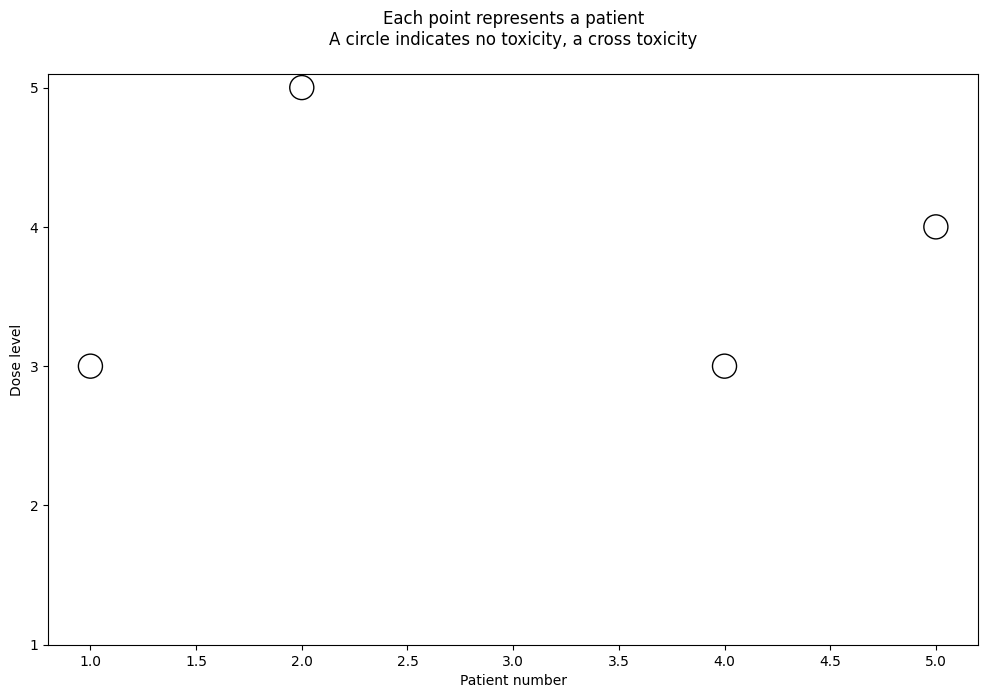

In [9]:
crm.plot_outcomes()

This chart shows the doses given to patients, where toxicities are represented with crosses and tolerances circles.

/app/clintrials/dosefinding/crm.py:805: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(


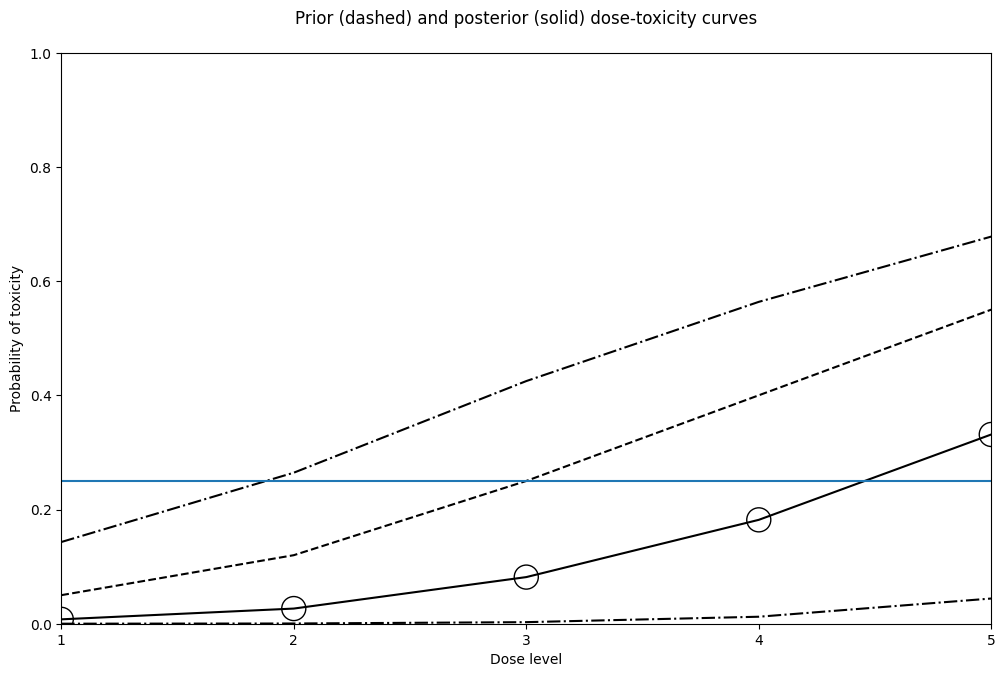

In [10]:
crm.plot_toxicity_probabilities()

This chart shows the prior and posterior dose-toxicity curves. The prior curve is shown with a dashed line and the updated
posterior curve, i.e. the curve reflecting both prior beliefs and observed data, is shown with a solid line.

### Example 2

In this example, we simulate a CRM trial. We assume a true, but unknown, probability of toxicity for each dose level. We then simulate the enrollment of patients in cohorts, and for each cohort, we use the CRM to decide the dose for the next cohort. The outcomes are simulated from the true toxicity probabilities. At the end of the trial, we can see how the CRM has learned about the dose-toxicity relationship.

/app/clintrials/common.py:57: RuntimeWarning: overflow encountered in exp
  return x ** np.exp(beta)


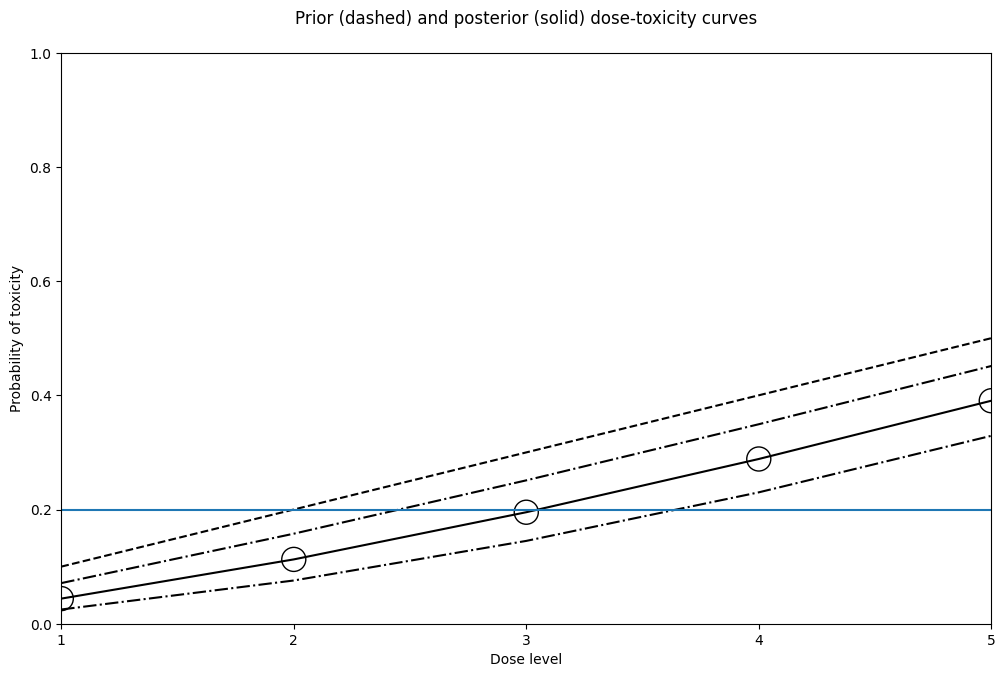

In [11]:
import numpy as np

# Priors and target
prior = [0.1, 0.2, 0.3, 0.4, 0.5]
target_toxicity = 0.2

# True toxicity probabilities (unknown to the model)
true_toxicity = [0.05, 0.1, 0.2, 0.3, 0.4]

# Simulation parameters
n_patients = 30
cohort_size = 3
n_cohorts = n_patients // cohort_size

# Starting dose
start_dose = 1

# Initialize CRM
crm_sim = CRM(prior, target_toxicity, first_dose=start_dose, max_size=n_patients)

# Store results
doses_given = []
toxicities_observed = []

current_dose = start_dose
for cohort in range(n_cohorts):
    # Administer dose to cohort
    for i in range(cohort_size):
        doses_given.append(current_dose)
        # Simulate toxicity based on true probability
        toxicity = np.random.binomial(1, true_toxicity[current_dose-1])
        toxicities_observed.append(toxicity)
    
    # Update CRM with observed data
    cases = list(zip(doses_given, toxicities_observed))
    current_dose = crm_sim.update(cases)

# Plot the final posterior dose-toxicity curve
crm_sim.plot_toxicity_probabilities()

#### References

O’Quigley J., Pepe M., and Fisher L. _Continual reassessment method: a practical design for phase 1 clinical
trials in cancer_. Biometrics. 1990 Mar; 46(1): p. 33-48.

Cheung, Y.K., _Dose Finding by the Continual Reassessment Method_, CRC Press, ISBN 9781420091519